# Import libraries

In [1]:
%matplotlib inline

import os
import sys
import shutil
print("Python:", sys.version)

import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Keras version:", tf.keras.__version__)

import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout, Dense, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint

import numpy as np
print("NumPy version:", np.__version__)

import scipy
from scipy.io import loadmat
print("SciPy version:", scipy.__version__)

import matplotlib
import matplotlib.pyplot as plt
print("Matplotlib version:", matplotlib.__version__)

import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print("scikit-learn version:", sklearn.__version__)

np.random.seed(99)
tf.random.set_seed(99)

Python: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
TensorFlow version: 2.18.0
Keras version: 3.8.0
NumPy version: 1.26.4
SciPy version: 1.13.1
Matplotlib version: 3.10.0
scikit-learn version: 1.6.1


# Download and load the CIFAR10 dataset

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
X_train = X_train / 255
y_train = keras.utils.to_categorical(y_train)
X_test = X_test / 255
y_test = keras.utils.to_categorical(y_test)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


# Drop Activation Layer

In [3]:
# Original Drop Activation from the research paper.
# Sourced and modified from
# https://github.com/LeungSamWai/Drop-Activation/blob/master/models/cifar/da_wrn.py


import tensorflow_probability as tfp

class DropActivation(Layer):
    def __init__(self, keep_prob=0.80, **kwargs):
        '''
        :param keep_prob: the probability of retaining the ReLU activation
        '''
        super(DropActivation, self).__init__()
        self.keep_prob = keep_prob

    def call(self, x, training=None):
        '''
        :param x: input of x
        :return: drop activation during training or testing phase
        '''
        size_len = len(x.shape)
        if training:
            # Bernoulli_mask = torch.cuda.FloatTensor(x.size()[0:size_len]).fill_(1)
            # Bernoulli_mask = tf.ones(x.shape)
            # Bernoulli_mask.bernoulli_(self.keep_prob)
            Bernoulli_distribution = tfp.distributions.Bernoulli(probs=self.keep_prob)
            Bernoulli_sample = Bernoulli_distribution.sample(x.shape[1:])
            Bernoulli_mask = Bernoulli_sample
            Bernoulli_mask = tf.cast(Bernoulli_mask, tf.float32)
            # temp = torch.Tensor().cuda()
            # output = torch.Tensor().cuda()
            # temp.resize_as_(x).copy_(x)
            # output.resize_as_(x).copy_(x)
            temp = tf.identity(x)
            output = tf.identity(x)
            # output.mul_(Bernoulli_mask)
            output = tf.math.multiply(output, Bernoulli_mask)
            # output.mul_(-1)
            output = tf.math.multiply(output, -1)
            # output.add_(temp)
            output = tf.math.add(output, temp)
            # temp.clamp_(min = 0)
            temp = tf.math.maximum(temp, 0)
            # temp.mul_(Bernoulli_mask)
            temp = tf.math.multiply(temp, Bernoulli_mask)
            # output.add_(temp)
            output = tf.math.add(output, temp)
            return output
        else:
            # temp = torch.Tensor().cuda()
            # output = torch.Tensor().cuda()
            # temp.resize_as_(x).copy_(x)
            # output.resize_as_(x).copy_(x)
            temp = tf.identity(x)
            output = tf.identity(x)
            # output.mul_(self.keep_prob)
            output = tf.math.multiply(output, self.keep_prob)
            # output.mul_(-1)
            output = tf.math.multiply(output, -1)
            # output.add_(temp)
            output = tf.math.add(output, temp)
            # temp.clamp_(min=0)
            temp = tf.math.maximum(temp, 0)
            # temp.mul_(self.keep_prob)
            temp = tf.math.multiply(temp, self.keep_prob)
            # output.add_(temp)
            output = tf.math.add(output, temp)
            return output

# Create model

In [4]:
# AlexNet architecture with Drop Activation.

model = tf.keras.Sequential([
    Input(shape=(32, 32, 3)),

    Conv2D(32, (5, 5), activation="relu", padding="valid"),
    MaxPooling2D((2,2)),
    BatchNormalization(),

    Conv2D(32, (3, 3), activation="relu", padding="valid"),
    MaxPooling2D((2,2)),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation="relu", padding="valid"),
    Conv2D(64, (1, 1), activation="relu", padding="valid"),
    Conv2D(128, (1, 1), activation="relu", padding="valid"),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(256),
    DropActivation(),
    Dense(128),
    DropActivation(),
    Dense(64),
    DropActivation(),
    Dropout(0.5),

    Dense(10, activation="softmax")
])

In [5]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 14, 14, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 12, 12, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 6, 6, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 64)            │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 4, 4, 128)           │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ drop_activation (DropActivation)     │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ drop_activation_1 (DropActivation)   │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ drop_activation_2 (DropActivation)   │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 216,042 (843.91 KB)

 Trainable params: 215,914 (843.41 KB)

 Non-trainable params: 128 (512.00 B)

# Train the model

In [6]:
best_model_saving_callback = ModelCheckpoint(filepath="Best Model.keras", monitor="val_accuracy", mode="max", save_best_only=True)

In [7]:
model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(), metrics=["accuracy"])

In [8]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=20, callbacks=[best_model_saving_callback])

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - accuracy: 0.3031 - loss: 1.8819 - val_accuracy: 0.4590 - val_loss: 1.5008
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5114 - loss: 1.3932 - val_accuracy: 0.5554 - val_loss: 1.2474
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.5732 - loss: 1.2327 - val_accuracy: 0.5618 - val_loss: 1.2295
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6161 - loss: 1.1264 - val_accuracy: 0.5726 - val_loss: 1.2334
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6411 - loss: 1.0461 - val_accuracy: 0.5620 - val_loss: 1.2764
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6660 - loss: 0.9809 - val_accuracy: 0.6178 - val_loss: 1.1085
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6857 - loss: 0.9287 - val_accuracy: 0.5685 - val_loss: 1.2763
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.7070 - loss: 0.874

In [9]:
# Save fully trained model and load the best model for further evaluation cells.
fully_trained_model = model
model = tf.keras.models.load_model("Best Model.keras", custom_objects={"DropActivation": DropActivation})

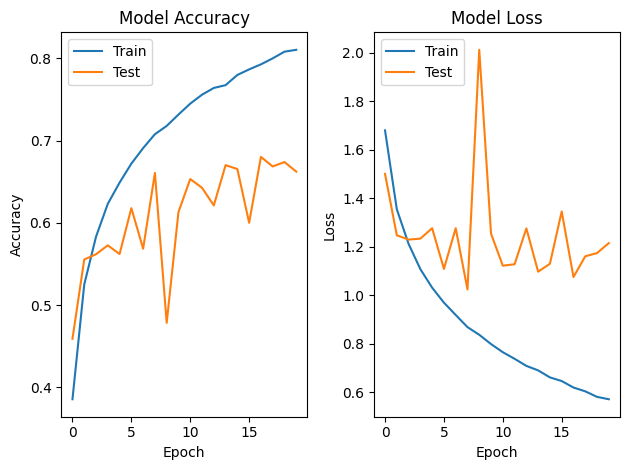

In [10]:
fig, axis = plt.subplots(1, 2)

axis[0].plot(history.history["accuracy"])
axis[0].plot(history.history["val_accuracy"])
axis[0].set_title("Model Accuracy")
axis[0].set_ylabel("Accuracy")
axis[0].set_xlabel("Epoch")
axis[0].legend(["Train", "Test"], loc="upper left")

# summarize history for loss
axis[1].plot(history.history["loss"])
axis[1].plot(history.history["val_loss"])
axis[1].set_title("Model Loss")
axis[1].set_ylabel("Loss")
axis[1].set_xlabel("Epoch")
axis[1].legend(["Train", "Test"], loc="upper left")

fig.tight_layout()
plt.show()

# Model Accuracy

In [11]:
d = model.evaluate(X_test, y_test, return_dict=True)
model_accuracy_truncated = int(d["accuracy"] * 100 * 100) / 100
d

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6846 - loss: 1.0762


{'accuracy': 0.6807000041007996, 'loss': 1.0888981819152832}

In [12]:
y_pred = model.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [13]:
model.compute_metrics(X_test, y_test, y_pred)

{'accuracy': 0.6807000041007996, 'loss': 1.0888981819152832}

In [14]:
cm = confusion_matrix(np.argmax(y_test, axis=-1), y_pred.argmax(axis=-1), normalize="true")

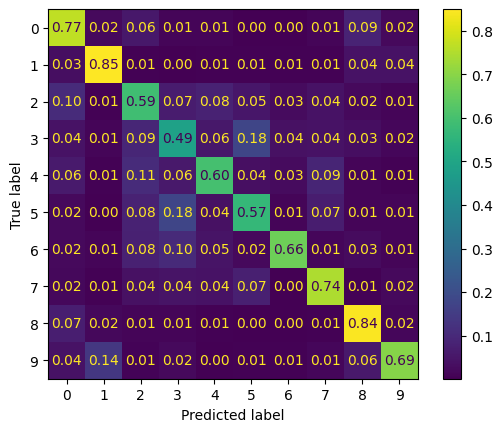

In [15]:
ConfusionMatrixDisplay.from_predictions(np.argmax(y_test, axis=-1), y_pred.argmax(axis=-1), normalize="true", values_format=".2f")

# Save model

In [16]:
model.save(f"CIFAR10 AlexNet DA {model_accuracy_truncated}.keras")

In [17]:
# Accuracy over 5 runs.
#
#
#
#
#
# Average: .